In [1]:
### decodingCallTypes 2 was used to select the group of units based on pair-wise comparisons that had sufficient data for ensemble analysis.

In [2]:
# Dependencies 
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pk
import multiprocessing as mp
from scipy.stats import t
from sklearn.naive_bayes import GaussianNB
from scipy.special import comb
from scipy.stats import norm


In [3]:
# Some paths
rootPath = '/Users/frederictheunissen/Google Drive/My Drive/julie/'
pklPath = 'pkl/'


# The 6 birds from Julie data set
birds = ['BlaBro09xxF', 'GreBlu9508M', 'WhiBlu5396M', 'LblBlu2028M', 'WhiWhi4522M', 'YelBlu6903F']

# Color code for call type
callColor = {'Be': (0/255.0, 230/255.0, 255/255.0), 'LT': (0/255.0, 95/255.0, 255/255.0), 'Tu': (255/255.0, 200/255.0, 65/255.0), 'Th': (255/255.0, 150/255.0, 40/255.0), 
             'Di': (255/255.0, 105/255.0, 15/255.0), 'Ag': (255/255.0, 0/255.0, 0/255.0), 'Wh': (255/255.0, 180/255.0, 255/255.0), 'Ne': (255/255.0, 100/255.0, 255/255.0),
             'Te': (140/255.0, 100/255.0, 185/255.0), 'DC': (100/255.0, 50/255.0, 200/255.0), 'So': (255/255.0, 255/255.0, 255/255.0)}



In [4]:
# Load the data base
outPath = rootPath+'JulieDataBase.pkl'
fileIn = open(outPath,"rb")
dfDataBase = pk.load(fileIn)
pcKDE = pk.load(fileIn)
fileIn.close()

In [5]:
dfDataBaseNW = dfDataBase[dfDataBase['call'] != 'Wh']

In [6]:
# Number of Units
unitNames = np.unique(dfDataBaseNW['site']+'_'+ dfDataBaseNW['unit'])
nunits = unitNames.shape[0]

# Number of Calls
callNames = np.unique(dfDataBaseNW['call'])
ncalls = callNames.shape[0]

# Stims per Units
nstimsUnit = dict()
unitNamesFull = []
for unit in unitNames:
    nstimsUnit[unit] = len(np.unique(dfDataBaseNW['stim'][dfDataBaseNW['site']+'_'+ dfDataBaseNW['unit'] == unit]))
    # Select only Units with 110 stimuli (for now)
    if (nstimsUnit[unit] >= 110):
        unitNamesFull.append(unit)
    
nunitsFull = len(unitNamesFull)

print(nunitsFull)



609


In [7]:
# Generate a list of all stimuli

stimNames = np.unique(dfDataBaseNW['stim'])
unitNames = np.unique(dfDataBaseNW['site']+'_'+ dfDataBaseNW['unit'])
callNames = np.unique(dfDataBaseNW['call'])

stimCount = np.zeros(len(stimNames))
callCount = np.zeros(len(callNames))

for unit in unitNamesFull:
    stimsUnit = np.unique(dfDataBaseNW['stim'][dfDataBaseNW['site']+'_'+ dfDataBaseNW['unit'] == unit].values)
    for istim, stim in enumerate(stimNames):
        if stim in stimsUnit:
            stimCount[istim] += 1            
            calltype = stim.split('_')[2]
            callCount[np.argwhere(callNames == calltype)] += 1
            

print(stimCount)
print(callCount)

[609. 609. 609. 228. 132. 132.  60.  28.  60. 228. 228. 161.  28. 132.
 161.  60.  28. 161. 609. 228. 161.  28.  60. 228. 132.  28. 132.  28.
 221. 132.  60. 161. 228. 609. 609. 609. 221.  28.  28. 228. 228. 161.
 132.  60. 132.  28. 161. 132. 228.  60. 161. 132.  28.  28. 228.  60.
  60. 132. 228. 161. 389. 389. 389. 228. 161. 161. 228. 161. 228. 389.
 389. 389. 228. 228. 161. 228. 161. 161. 161. 161. 228. 228. 161. 228.
 191. 191. 191. 103.  60. 131.  60.  28.  28.  60. 103.  28. 103. 103.
  60.  28. 103.  60.  28.  60.  60. 103.  28. 103.  28. 103.  60.  60.
  28. 161. 161. 161. 161. 161. 161. 161. 161. 161. 161. 161. 161. 161.
 161. 161. 345. 345. 345. 163. 163. 163. 103. 103. 103. 103. 103. 103.
 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103.  28.  28.  28.
 264. 264. 264. 609. 609. 609. 161.  28. 132. 161.  28. 132.  60. 228.
  28. 228.  60. 132. 389.  60. 477. 477. 609.  28. 228. 161.  60. 132.
 228. 161.  28.  60. 132.  28.  60. 161. 132. 228. 418. 418. 418. 228.
 161. 

In [8]:
sum(stimCount>100)

279

In [8]:
print(callNames)

['Ag' 'Be' 'DC' 'Di' 'LT' 'Ne' 'So' 'Te' 'Th']


In [9]:
def naiveBayes(unitChoice, plotFlg = False, usingAllCombos = False, code='PC', verbose = False):
    # naiveBayes runs a guassian classifier for call types using the responses in the units in the list unitChoice
    
    
    # Number of units
    numUnits = len(unitChoice)
    
    # Number of PCs (for PC code)
    nPCs = dfDataBaseNW['PC'][0].shape[0]
    
    # Find the unique stims played for the chosen unit
    unitIndexDict = dict()
    unitIndexLen = []
    stimList = []
    for unit in unitChoice:   
        unitIndex = dfDataBaseNW.index[dfDataBaseNW['site']+'_'+ dfDataBaseNW['unit'] == unit]
        unitIndexDict[unit] = unitIndex
        unitIndexLen.append(len(unitIndex))
        stimList.extend(list(dfDataBaseNW['stim'][unitIndex].array))
    
    stimNames = np.unique(stimList)
    
    # Generate ensemble responses  for the units in unitChoice

    # Training Trials
    rowListList = []
    totTrials = 0

    # Testing Trials
    rowListListTest = []
    totTestTrials = 0

    for stim in stimNames:
        goodStim = 2    # This means that we have at least two trials for each stim for all units
        
        # Check to see if we have enough trials for all units for this stim
        for unit in unitChoice:
            unitIndex = unitIndexDict[unit]
            unitIndexStim = [ind for ind in unitIndex if dfDataBaseNW['stim'][ind] == stim]
            if len(unitIndexStim) == 0:
                goodStim = 0
                if verbose:
                    print('Stim ', stim, 'has no response for unit', unit, '. Skipping')
                break
            elif len(unitIndexStim) == 1:
                goodStim = 1
            
        # If so continue
        if goodStim > 0 :
            rowList2Cat = []
            rowList2CatLen = []
            for unit in unitChoice:
                unitIndex = unitIndexDict[unit]
                unitIndexStim = [ind for ind in unitIndex if dfDataBaseNW['stim'][ind] == stim]
                rowList2Cat.append(unitIndexStim)
                rowList2CatLen.append(len(unitIndexStim))
            
            if goodStim > 1 :  # Use one of the responses for the test set
                listTest = []
                for iunit, unit in enumerate(unitChoice):
                    rowchosen = np.random.choice(rowList2Cat[iunit], 1, replace=False)
                    listTest.append(rowchosen[0])
                    rowList2Cat[iunit].remove(rowchosen)
                    rowList2CatLen[iunit] = len(rowList2Cat[iunit])
                rowListListTest.append(listTest)
                totTestTrials +=1
            
            if usingAllCombos:
                numSamp = np.prod(rowList2CatLen)
                totTrials += numSamp
            
                list_of_lists = []

                indUnit = np.zeros((numUnits,), dtype=int)
                indUnit[0] = -1
            
                for i in range(numSamp):
                    for iunit, unit in enumerate(unitChoice):
                        indUnit[iunit] += 1
                        if (indUnit[iunit] >= len(rowList2Cat[iunit]) ):
                            indUnit[iunit] = 0
                        else: 
                            break
                    trialList = []
                    for iunit, unit in enumerate(unitChoice):
                        trialList.append(rowList2Cat[iunit][indUnit[iunit]])
                
                    list_of_lists.append(trialList)
            else:
                numSamp = np.max(rowList2CatLen)
                totTrials += numSamp
                    
                list_of_lists = []
                for i in range(numSamp):
                    trialList = []
                    for iunit, unit in enumerate(unitChoice):
                        if i < len(rowList2Cat[iunit]):
                            trialList.append(rowList2Cat[iunit][i])
                        else:
                            trialList.append(np.random.choice(rowList2Cat[iunit], 1, replace=False)[0])
                    list_of_lists.append(trialList)
        
            rowListList.extend(list_of_lists)

    if verbose:        
        print('Total number of trials:', totTrials)
        print('Total number of test trials:', totTestTrials)
    
    # Make X (neural code), Y (call type)
    if code == 'z':
        Xfit = np.zeros((totTrials, numUnits*1))
        Xtest = np.zeros((totTestTrials, numUnits*1))
    elif code == 'PC':
        Xfit = np.zeros((totTrials, numUnits*(1+nPCs)))
        Xtest = np.zeros((totTestTrials, numUnits*(1+nPCs)))
        
    Yfit = []
    for irow,rowList in enumerate(rowListList):
        if code == 'z':
            Xfit[irow,:] = dfDataBaseNW['z'][rowList].array
        elif code == 'PC':
            Xfit[irow,:] = np.hstack([np.hstack((dfDataBaseNW['z'][ind], dfDataBaseNW['PC'][ind])) for ind in rowList])
            
        Yfit.append(np.unique(dfDataBaseNW['call'][rowList].array)[0])
    Yfit = np.array(Yfit)

    
    Ytest = []
    for irow,rowList in enumerate(rowListListTest):
        if code == 'z':
            Xtest[irow,:] = dfDataBaseNW['z'][rowList].array
        elif code == 'PC':
            Xtest[irow,:] = np.hstack([np.hstack((dfDataBaseNW['z'][ind], dfDataBaseNW['PC'][ind])) for ind in rowList])
        Ytest.append(np.unique(dfDataBaseNW['call'][rowList].array)[0])
    
    Ytest = np.array(Ytest)
    
    
    # Fit and test the classifier clf
    nClasses = len(np.unique(Yfit))

    clf = GaussianNB(priors=np.ones((nClasses,))/nClasses)
    clf.fit(Xfit,Yfit)

    probTest = clf.predict_proba(Xtest)

    # Make a confusion matrix
    confMat = np.zeros((nClasses,nClasses))
    testsPerClass = np.zeros((nClasses,))
    fitsPerClass = np.zeros((nClasses,))

    for y in Yfit:
        classID = np.argwhere(clf.classes_ == y)
        fitsPerClass[classID] += 1
        
    for i,y in enumerate(Ytest):
        classID = np.argwhere(clf.classes_ == y)
        testsPerClass[classID] += 1    
        confMat[classID,:] += probTest[i]
    
    # The confusion matrix is not normalized so that we can average it correctly later on.. 
    #for i in range(nClasses):
    #    confMat[i,:] /= testsPerClass[i]
    
    # Print percent correct classification by taking average of diagonal of confusion matrix.
    sumCorrect = np.trace(confMat)
    sumTest = np.sum(testsPerClass)
    pcc = 100.0*(sumCorrect/sumTest)
    
    if verbose:
        print('PCC %.0f %%' % (pcc))
    
    if plotFlg:
        # Normalize confMat for display
        confMatNorm = np.zeros((nClasses,nClasses))
        for i in range(nClasses):
            if testsPerClass[i] > 0 :
                confMatNorm[i,:] = confMat[i,:]/testsPerClass[i]
                
        # Display comfusion matrix
        cmap='viridis'
        fig, ax = plt.subplots()
        im_ = ax.imshow(confMatNorm*100.0, interpolation='nearest', cmap=cmap)

        fig.colorbar(im_, ax=ax)
        ax.set(xticks=np.arange(nClasses),
               yticks=np.arange(nClasses),
               xticklabels=clf.classes_,
               yticklabels=clf.classes_,
               ylabel="Actual Call Type",
               xlabel="Predicted Call Type",
               title='PPC %.0f %%' % (pcc))
    
    return pcc, confMat, testsPerClass, fitsPerClass



In [10]:
def naiveBayesFET(unitChoice, plotFlg = False, code='PC', verbose = False, weightedVote = False):
    # naiveBayes runs a guassian classifier for call types using the responses in the units in the list unitChoice
    # The FET version calculates the parameters of the gaussian for each unit.
    # I tried one version with a weighted sum of probabilities that failed.  That code is active when weightedVote is set to true.
    # Noted differences with scikit-learn: 
    # 1. FET uses the unbiased estimate of the variance of the guassian, scikit uses the ML estimate (which is biased)
    # 2. scikit adds an epsilon to this variance wich is 1e-9*max of variance
    
    # Number of units
    numUnits = len(unitChoice)    
    # Number of PCs (for PC code)
    nPCs = dfDataBase['PC'][0].shape[0]
    # Number of calls is ncalls with names callNames
        
    # Find the unique stims played for the chosen unit
    unitIndexDict = dict()
    unitIndexLen = []
    stimList = []
    for unit in unitChoice:   
        unitIndex = dfDataBase.index[dfDataBase['site']+'_'+ dfDataBase['unit'] == unit]
        unitIndexDict[unit] = unitIndex
        unitIndexLen.append(len(unitIndex))
        stimList.extend(list(dfDataBase['stim'][unitIndex].array))
    
    stimNames = np.unique(stimList)
    
    # Find testing and training trials for each stim

    # Training data for each unit
    unitRowList = [[]] * numUnits

    # Testing Trials - One for each stim
    rowListListTest = []
    totTestTrials = 0

    for stim in stimNames:
        goodStim = 2    # This means that we have at least two trials for each stim for all units
        
        # Check to see if we have enough trials for all units for this stim
        for unit in unitChoice:
            unitIndex = unitIndexDict[unit]
            unitIndexStim = [ind for ind in unitIndex if dfDataBase['stim'][ind] == stim]
            if len(unitIndexStim) == 0:
                goodStim = 0
                print('Stim ', stim, 'has no response for unit', unit, '. Skipping')
                break
            elif len(unitIndexStim) == 1:
                goodStim = 1
            
        # If so continue
        if goodStim > 0 :
            rowList2Cat = []
            for unit in unitChoice:
                unitIndex = unitIndexDict[unit]
                unitIndexStim = [ind for ind in unitIndex if dfDataBase['stim'][ind] == stim]
                rowList2Cat.append(unitIndexStim)
                      
            listTest = []
            for iunit, unit in enumerate(unitChoice):
                rowchosen = np.random.choice(rowList2Cat[iunit], 1, replace=False)
                listTest.append(rowchosen[0])
                rowList2Cat[iunit].remove(rowchosen)
                unitRowList[iunit].extend(rowList2Cat[iunit])
            
            rowListListTest.append(listTest)
            totTestTrials +=1
    
    # For each unit generate mean, variance, and number of trials for each call type.
    unitGaussianModelList = [None]*numUnits
    for iunit, unit in enumerate(unitChoice):
        unitGaussianModelList[iunit] = [None]*ncalls 
        for icall, call in enumerate(callNames):
            unitModel = dict()
            unitModel['count'] = 0
            unitModel['call'] = call
            
            # Rows for this unit and call:
            rowList = [ind for ind in unitRowList[iunit] if dfDataBase['call'][ind] == call]
            
            if len(rowList) > 2:
                if code == 'z':
                    unitModel['means'] = np.mean(dfDataBase['z'][rowList].values, axis = 0)
                    unitModel['stds'] = np.std(dfDataBase['z'][rowList].values, axis = 0, ddof = 1)
                elif code == 'PC':
                    unitModel['means'] = np.hstack((np.mean(dfDataBase['z'][rowList].values, axis = 0), np.mean(dfDataBase['PC'][rowList].values, axis = 0)))
                    unitModel['stds'] = np.hstack((np.std(dfDataBase['z'][rowList].values, axis = 0, ddof=1), np.std(dfDataBase['PC'][rowList].values, axis = 0, ddof = 1)))

                unitModel['count'] = len(rowList) - 2 
            
            unitGaussianModelList[iunit][icall] = unitModel
  
    # Calculate test probabilities  
    confMat = np.zeros((ncalls,ncalls))
    testsPerClass = np.zeros((ncalls,))
    
    for irow,rowList in enumerate(rowListListTest):

        ytest = np.unique(dfDataBase['call'][rowList].array)[0]
        probCall = np.zeros(ncalls)
        if verbose:
            print('++++++++++++++++++++++++ Call test', ytest, '++++++++++++++++++++++')
            print(callNames)

        for iunit, unit in enumerate(unitChoice):
            unitVotes = 0
            probUnit = np.zeros(ncalls)
            if code == 'z':
                xtest = dfDataBase['z'][rowList[iunit]]
            elif code == 'PC':
                xtest = np.hstack((dfDataBase['z'][rowList[iunit]], dfDataBase['PC'][rowList[iunit]]))
            for icall, call in enumerate(callNames):
                unitModel = unitGaussianModelList[iunit][icall]
                unitVotes += unitModel['count']
                if unitModel['count']:
                    probval = 0
                    for i, xval in enumerate(xtest):
                        probval += norm.logpdf(xval, loc = unitModel['means'][i], scale =  unitModel['stds'][i])
                    probUnit[icall] = np.exp(probval)
                else:
                    probUnit[icall] = np.nan
            
            # Fix nans
            meanProb = np.nanmean(probUnit)
            for icall, call in enumerate(callNames):
                if np.isnan(probUnit[icall]):
                    probUnit[icall] = meanProb
                    
            # Calculate contribution of this unit
            if weightedVote:
                sumProb = np.sum(probUnit)
                probUnit = probUnit*unitVotes/sumProb
                probCall += probUnit
            else:
                probUnit = np.log(probUnit)
                probCall += probUnit
            
            if verbose:
                print('\n----Adding unit', iunit)
                print(probUnit)
                print(probCall)

                          
        # Final normalization
        if ~weightedVote:
            probCall = np.exp(probCall-np.mean(probCall))
        probCall = probCall/np.sum(probCall)

        
        # Fill in the data
        classID = np.argwhere(callNames == ytest)[0]
        testsPerClass[classID] += 1    
        confMat[classID,:] += probCall
        if verbose:
            print('\n------- FINAL')
            print(ytest, classID)
            print(callNames)
            print(probCall)
            print(confMat[classID,:])
        
        
    # Print percent correct classification by taking average of diagonal of confusion matrix.
    sumCorrect = np.trace(confMat)
    sumTest = np.sum(testsPerClass)
    pcc = 100.0*(sumCorrect/sumTest)
    
    if verbose:
        print('PCC %.0f %%' % (pcc))
    
    if plotFlg:
        # Normalize confMat for display
        confMatNorm = np.zeros((ncalls,ncalls))
        for i in range(ncalls):
            if testsPerClass[i] > 0 :
                confMatNorm[i,:] = confMat[i,:]/testsPerClass[i]
                
        # Display comfusion matrix
        cmap='viridis'
        fig, ax = plt.subplots()
        im_ = ax.imshow(confMatNorm*100.0, interpolation='nearest', cmap=cmap)

        fig.colorbar(im_, ax=ax)
        ax.set(xticks=np.arange(ncalls),
               yticks=np.arange(ncalls),
               xticklabels=callNames,
               yticklabels=callNames,
               ylabel="Actual Call Type",
               xlabel="Predicted Call Type",
               title='PPC %.0f %%' % (pcc))
    
    return pcc, confMat, testsPerClass

In [5]:
# Read the results of Part 1 Runs that includes all neurons

# Read the PC and Confusion matrices data base
inPath = rootPath+pklPath+'JulieDataBase1UnitPCNW.pkl'
fileIn = open(inPath,"rb")
unitNamesFull = pk.load(fileIn)
confMatTot = pk.load(fileIn)
pcc = pk.load(fileIn)
fileIn.close()

# These are the neurons that we will be keeping
indGood = np.argwhere(pcc > 13).flatten()           # 13 instead of 12 because only 9 call types
nGood = indGood.shape[0]

In [6]:
pccGood = pcc[indGood]
unitNamesGood = [unitNamesFull[i] for i in indGood]

indSort = np.flip(np.argsort(pccGood))

    
# Printing the name of the most discriminating units
birdName = []
for ind in indSort:
    print(unitNamesGood[ind], pccGood[ind])
    birdName.append(unitNamesGood[ind][0:4])
    
birdUnique = np.unique(birdName)
for bird in birdUnique:
    print(bird, ":", len([x for x in birdName if x == bird]))

Site3_L1200R1200_e22_s0_ss1 38.96906490615552
Site3_L1200R1200_e2_s0_ss3 38.128759980816
Site4_L1500R1900_e22_s0_ss1 37.28757516208641
Site4_L1500R1500_e16_s0_ss2 36.9865150878067
Site5_L2450R2350_e20_s0_ss2 35.97655345446542
Site3_L1250R1650_e2_s0_ss1 34.73578059117604
Site3_L1200R1200_e4_s0_ss1 34.31821576434347
Site4_L1500R1500_e16_s0_ss1 34.305730918177936
Site3_L1900R1800_e32_s0_ss1 33.59111375406576
Site3_L1250R1650_e21_s0_ss2 33.55903497425244
Site3_L1250R1650_e13_s0_ss1 33.259007344072025
Site3_L1200R1200_e15_s0_ss1 32.84254086256089
Site3_L1250R1650_e21_s0_ss1 32.12464178956216
Site3_L1250R1650_e14_s0_ss1 31.810625935382674
Site4_L1500R1900_e4_s0_ss1 31.361108679177313
Site4_L1500R1900_e12_s0_ss1 30.996861938580654
Site4_L2100R2050_e18_s0_ss2 30.526428110257907
Site4_L2100R2050_e30_s0_ss2 30.176324540063742
Site3_L1200R1200_e3_s0_ss1 30.066031485430532
Site2_L1100R1450_e3_s0_ss2 29.67763724134116
Site5_L1800R2100_e22_s0_ss2 29.52243727915384
Site1_L1500R1500_e19_s0_ss1 29.3274

In [4]:
nGood

408

In [11]:
# Generates the common stimulus set
def commonStim(siteUnit, unitList):
      
    for i, unit in enumerate(unitList):
        tempStims = np.unique(dfDataBaseNW['stim'][siteUnit==unit].values)
        if i == 0 :
            stimSet = set(tempStims)
        stimSet = stimSet.intersection(tempStims)
                               
    return stimSet
        

In [12]:
# Get a new unitList that has pairs of neurons with at least 100 common stim.

siteUnit = (dfDataBaseNW['site']+'_'+dfDataBaseNW['unit'])
argList = []
for i1, ind1 in enumerate(indGood):
    unit1 = unitNamesFull[ind1]
    for i2, ind2 in enumerate(indGood):
        if i2 <= i1:
            continue
        unit2 = unitNamesFull[ind2]
        unitChoice = [unit1, unit2]
        stimSet = commonStim(siteUnit, unitChoice)
        # print(len(stimSet))
        if ( len(stimSet) > 100 ):
            argList.append(unitChoice)

unitList = np.unique([unit for sublist in argList for unit in sublist])
argList2 = argList.copy()


In [39]:
# save unitList and argList2 and Confusion matrices data base
outPath = rootPath+ pklPath + 'JulieDataBaseGoodUnitList.pkl' 
fileOut = open(outPath,"wb")
pk.dump(argList2, fileOut)
pk.dump(unitList, fileOut)

fileOut.close()

In [33]:
numUnits = 2
ntests = len(argList2)

In [52]:
# For 1 and 2 - all permutations are done 
numUnits = 2

nGood = len(unitList)
maxTest = 10000


ntests = int(comb(nGood,numUnits))
if ntests > maxTest:
    ntests = maxTest
    

# Generate the list of arguments to run naiveBayes in parallel
argList = []
if numUnits == 1:
    for i, unit in enumerate(unitList):
        if i == ntests:
            break
        unitChoice = [unit]
        argList.append(unitChoice)
elif numUnits == 2:  
    i = 0
    for i1, unit1 in enumerate(unitList):
        if i1 == ntests:
            break
        for i2, unit2 in enumerate(unitList):
            if i2 <= i1:
                continue
            if i2 == ntests:
                break
            unitChoice = [unit1, unit2]
            stimSet = commonStim(unitChoice)
            if ( len(stimSet) > 100 ):
                argList.append(unitChoice)
                i += 1
else:
    i = 0
    while i <ntests:
        unitChoice = np.random.choice(unitList, numUnits, replace=False)
        stimSet = commonStim(unitChoice)
        if ( len(stimSet) > 100 ):
            argList.append(unitChoice)
            i += 1
        else:
            print(len(stimSet))
        


In [34]:
code = 'PC'

# Run Naive Bayes in chunks of 100 with a pool of 10 workers
chunckSize = 100    # A chunk size of 100 is used for memory since it has to keep the results of all
poolSize = 30

# Allocate memory for results
pcc = np.zeros((ntests,))
confMatTot = np.zeros((ncalls, ncalls))
confMatCount = 0
confMatFits = 0

# Calculate the number of chunks
nchunks = ntests//chunckSize
if nchunks % chunckSize:
    nchunks += 1

if __name__ == '__main__':
    for ichunk in range(nchunks):
        istart = ichunk*chunckSize
        iend = (ichunk+1)*chunckSize
        if iend > ntests:
            iend = ntests         
        
        with mp.Pool(poolSize) as p:
            results = p.map(naiveBayes, argList[istart:iend])
        
        # I don't think I need these??
        # p.close()
        # p.join()
        
        for i, res in enumerate(results):
            pcc[istart + i] = res[0]
            confMat = res[1]
            testsPerClass = res[2]
            fitsPerClass = res[3]
            if (confMat.shape == (ncalls,ncalls) ) :
                confMatTot = np.add(confMatTot, confMat)
                confMatCount += testsPerClass
                confMatFits += fitsPerClass
                
        print('Done with chunk %d/%d' % (ichunk, nchunks))

# Calculate the average confusion matrix. 
for i in range(ncalls):
    if confMatCount[i] > 0:
        confMatTot[i,:] = confMatTot[i,:]/confMatCount[i]
        
# save the PC and Confusion matrices data base
outPath = rootPath+ pklPath + 'JulieDataBase%dGoodUnitPC.pkl' % numUnits
fileOut = open(outPath,"wb")
pk.dump(argList, fileOut)
pk.dump(confMatTot, fileOut)
pk.dump(pcc, fileOut)
pk.dump(confMatCount, fileOut)
pk.dump(confMatFits, fileOut)
fileOut.close()




Done with chunk 0/228
Done with chunk 1/228
Done with chunk 2/228
Done with chunk 3/228
Done with chunk 4/228
Done with chunk 5/228
Done with chunk 6/228
Done with chunk 7/228
Done with chunk 8/228
Done with chunk 9/228
Done with chunk 10/228
Done with chunk 11/228
Done with chunk 12/228
Done with chunk 13/228
Done with chunk 14/228
Done with chunk 15/228
Done with chunk 16/228
Done with chunk 17/228
Done with chunk 18/228
Done with chunk 19/228
Done with chunk 20/228
Done with chunk 21/228
Done with chunk 22/228
Done with chunk 23/228
Done with chunk 24/228
Done with chunk 25/228
Done with chunk 26/228
Done with chunk 27/228
Done with chunk 28/228
Done with chunk 29/228
Done with chunk 30/228
Done with chunk 31/228
Done with chunk 32/228
Done with chunk 33/228
Done with chunk 34/228
Done with chunk 35/228
Done with chunk 36/228
Done with chunk 37/228
Done with chunk 38/228
Done with chunk 39/228
Done with chunk 40/228
Done with chunk 41/228
Done with chunk 42/228
Done with chunk 43/22

In [35]:
confMatCount

array([243732., 267456., 369642., 158688., 175884., 319554., 617175.,
       409482., 165303.])

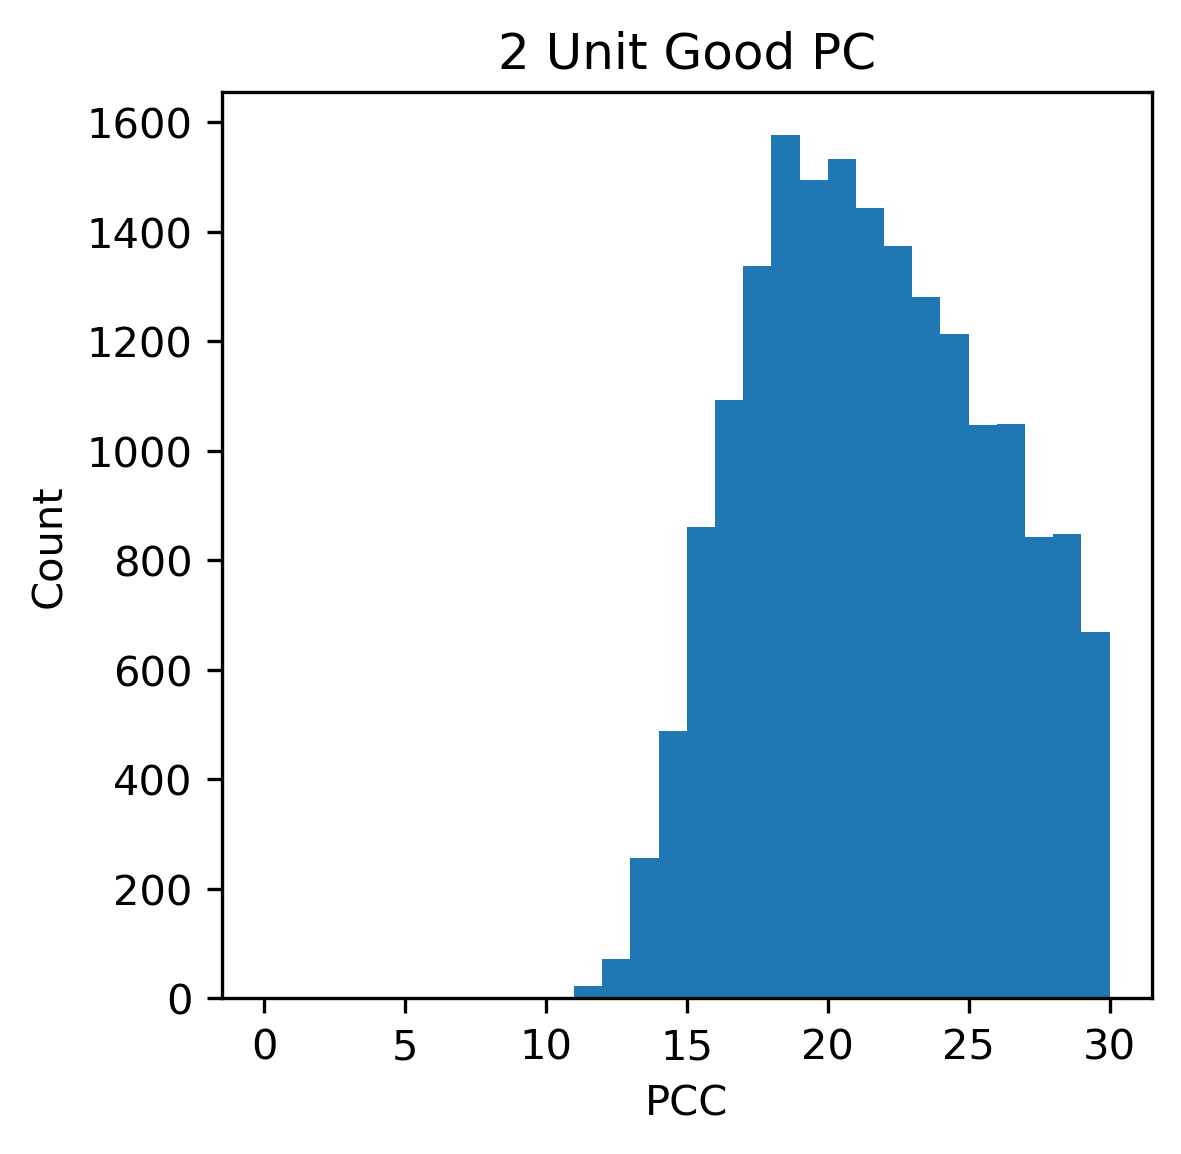

In [36]:
fig = plt.figure(figsize=(4,4), dpi=300)
ax = fig.subplots()

ax.hist(pcc, bins = 30, range = (0,30))
ax.set_xlabel('PCC')
ax.set_ylabel('Count')
ax.set_title('%d Unit Good PC' % numUnits)

plt.savefig('/Users/frederictheunissen/Desktop/pcchist%dUnitGoodPCJulie.eps' % numUnits)

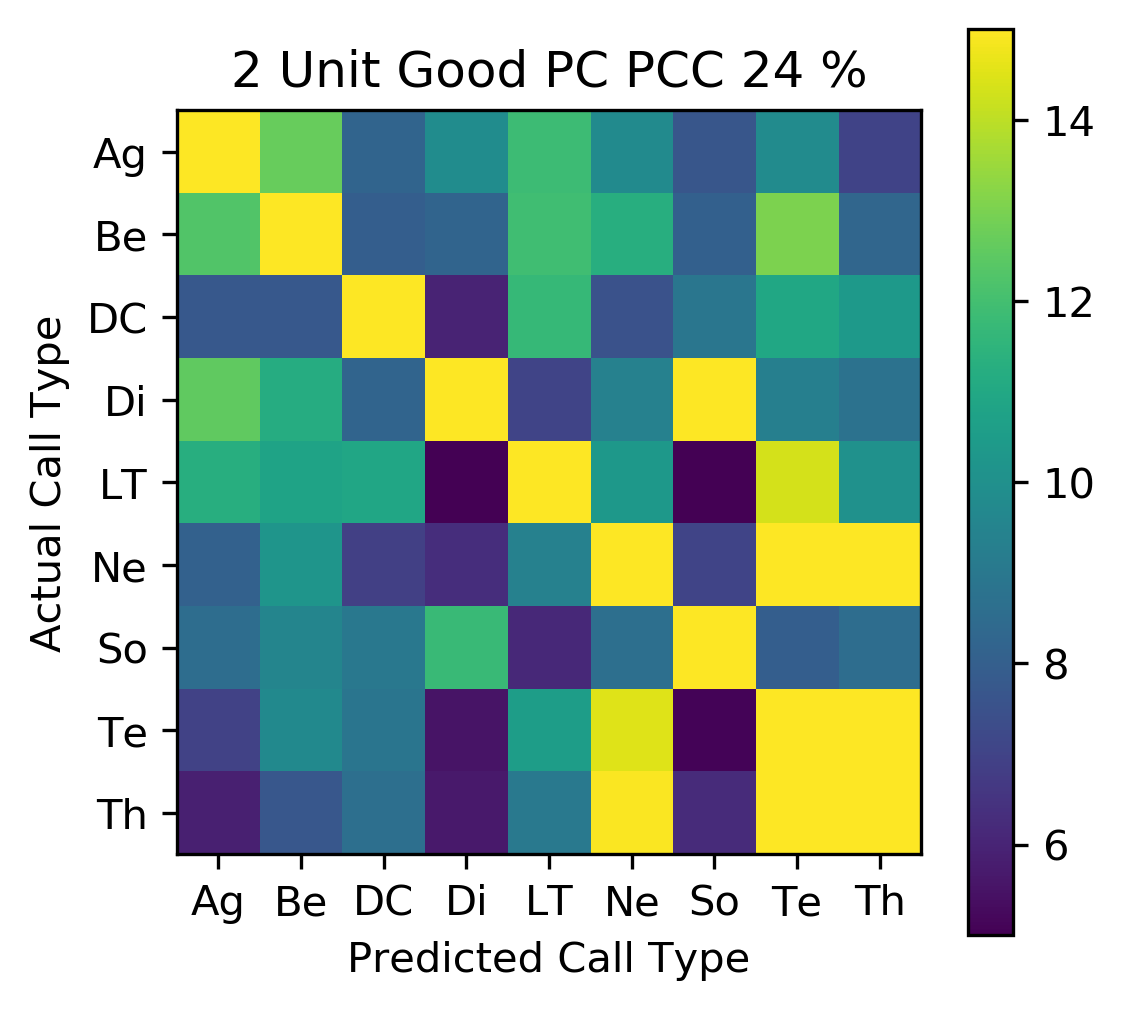

In [37]:
# Plot the overall confusion matrix

cmap='viridis'
fig = plt.figure(figsize=(4,4), dpi=300)
ax = fig.subplots()
im_ = ax.imshow(confMatTot*100.0, interpolation='nearest', cmap=cmap, extent = (-0.5, ncalls-0.5, ncalls-0.5, -0.5), vmin=5, vmax = 15)

fig.colorbar(im_, ax=ax)
ax.set(xticks=np.arange(ncalls),
               yticks=np.arange(ncalls),
               ylim = (ncalls-0.5, -0.5),
               xticklabels=callNames,
               yticklabels=callNames,
               ylabel="Actual Call Type",
               xlabel="Predicted Call Type",
               title='%d Unit Good PC PCC %.0f %%' % (numUnits, np.mean(pcc)))

plt.savefig('/Users/frederictheunissen/Desktop/confMat%dUnitGoodPCJulie.eps' % numUnits)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


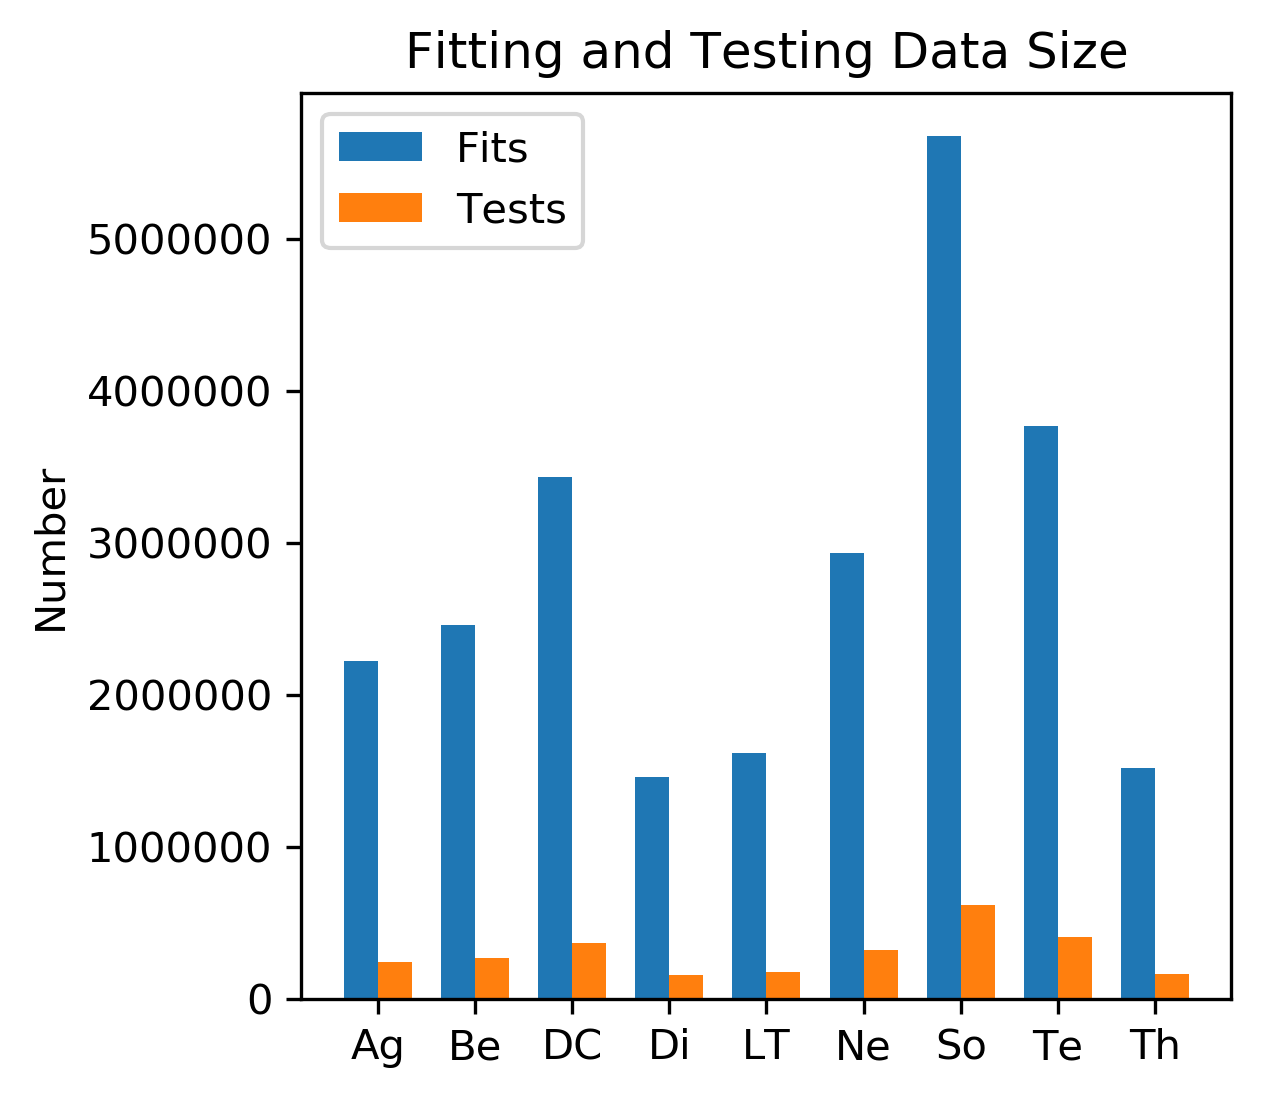

In [38]:
fig = plt.figure(figsize=(4,4), dpi=300)
ax = fig.subplots()

x = np.arange(len(callNames))  # the label locations
width = 0.35  # the width of the bars

rects1 = ax.bar(x - width/2, confMatFits, width, label='Fits')
rects2 = ax.bar(x + width/2, confMatCount, width, label='Tests')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number')
ax.set_title('Fitting and Testing Data Size')
ax.set_xticks(x)
ax.set_xticklabels(callNames)
ax.legend()

plt.savefig('/Users/frederictheunissen/Desktop/dataSize%dUnitGoodPCJulie.eps' % numUnits)